In this notebook, we are going to test all the datasets and visualize some results to ensure global explainability and to verify that the model is able to interpret the predictions reasonably.

In [1]:
import torch.nn.functional as F
from torch_explain.nn.concepts import ConceptReasoningLayer, ConceptReasoningLayerMod, ReasoningLinearLayer
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch_explain as te
from torch_explain import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from Models.ResLinLayer_NN.state_dict import *
%matplotlib inline
import logging
import warnings
warnings.filterwarnings('ignore')
# Set the logging level for matplotlib to WARNING to suppress debug information
logging.getLogger('matplotlib').setLevel(logging.WARNING)


PATH = 'Models\ResLinLayer_NN\state_dict'

2024-06-18 20:26:34,544 - matplotlib - DEBUG - matplotlib data path: d:\Github\pytorch_explain\env\Lib\site-packages\matplotlib\mpl-data
2024-06-18 20:26:34,552 - matplotlib - DEBUG - CONFIGDIR=C:\Users\a_h9\.matplotlib
2024-06-18 20:26:34,575 - matplotlib - DEBUG - interactive is False
2024-06-18 20:26:34,576 - matplotlib - DEBUG - platform is win32
2024-06-18 20:26:34,647 - matplotlib - DEBUG - CACHEDIR=C:\Users\a_h9\.matplotlib
2024-06-18 20:26:34,652 - matplotlib.font_manager - DEBUG - Using fontManager instance from C:\Users\a_h9\.matplotlib\fontlist-v390.json
2024-06-18 20:26:34,956 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-06-18 20:26:34,960 - matplotlib.pyplot - DEBUG - Loaded backend inline version unknown.


# Dataset 1: Is Bin EVEN

In [2]:
x, c, y = datasets.is_bin_even(100)

# Encode target into one-hode y=[y_0, y_1]
y = F.one_hot(y.long().ravel()).float()

# Define the concept_encoder
embedding_size = 8
concept_encoder = torch.nn.Sequential(
    torch.nn.Linear(x.shape[1], 10),
    torch.nn.LeakyReLU(),
    te.nn.ConceptEmbedding(10, c.shape[1], embedding_size),
)

# Define the DCR as task predictor
task_predictor = ConceptReasoningLayer(
    embedding_size, y.shape[1])

dummy_c_emb, dummy_c_pred = concept_encoder(x)
dummy_y, dummy_sign, dummy_filter = task_predictor(
    dummy_c_emb, dummy_c_pred, return_attn=True)

global_linearity = ReasoningLinearLayer(
    dummy_sign.shape[1], dummy_filter.shape[1], y.shape[1], modality='NN')

# Create a sequential model (cascaded)
model = torch.nn.Sequential(
    concept_encoder, task_predictor, global_linearity)


model.load_state_dict(torch.load(PATH+'\model_state_dict_LLRNN_IsBinEven.pth'))

<All keys matched successfully>

In [3]:
cem = model[0]
dcr = model[1]
llr = model[2]
cem.eval()
dcr.eval()
llr.eval()
c_emb , c_pred = cem(x)
y_pred, sign_attn, filter_attn = dcr(c_emb, c_pred, return_attn=True)
pred , coeffs, bias = llr(sign_attn, filter_attn, c_pred, return_params=True)

In [4]:
pred = torch.sigmoid(pred) # [0] for y_0, [1] for y_1

In [5]:
df = pd.DataFrame({
    'c_0': c[:, 0],
    'c_1': c[:, 1],
    'c_2': c[:, 2],
    'c_3': c[:, 3],
    'y_true_0': y[:, 0],
    'y_true_1': y[:, 1],
    'y_pred_0': pred[:, 0].detach().numpy(),
    'y_pred_1': pred[:, 1].detach().numpy(),
    'coeffs_c0_y0': coeffs[:,0,0].detach().numpy(),
    'coeffs_c1_y0': coeffs[:,1,0].detach().numpy(),
    'coeffs_c2_y0': coeffs[:,2, 0].detach().numpy(),
    'coeffs_c3_y0': coeffs[:,3, 0].detach().numpy(),
    'coeffs_c0_y1': coeffs[:,0, 1].detach().numpy(),
    'coeffs_c1_y1': coeffs[:,1, 1].detach().numpy(),
    'coeffs_c2_y1': coeffs[:,2, 1].detach().numpy(),
    'coeffs_c3_y1': coeffs[:,3, 1].detach().numpy(),
    'bias_y0': bias[:, 0].detach().numpy(),
    'bias_y1': bias[:, 1].detach().numpy(),
})

#### Important:
For this dataset, a number is even is the $c_3$ is even (i.e. equal to zero).\
The output of $y_0$ is 0 ($y_1$ is 1) means that the number IS EVEN.

In [6]:
df.head()

,c_0,c_1,c_2,c_3,y_true_0,y_true_1,y_pred_0,y_pred_1,coeffs_c0_y0,coeffs_c1_y0,coeffs_c2_y0,coeffs_c3_y0,coeffs_c0_y1,coeffs_c1_y1,coeffs_c2_y1,coeffs_c3_y1,bias_y0,bias_y1
0,0.0,1.0,1.0,1.0,1.0,0.0,0.999750,0.000242,-0.617367,-0.104577,-0.116672,8.825126,0.620312,0.113863,0.132209,-8.162219,5.898506,-6.153701
1,0.0,0.0,0.0,1.0,1.0,0.0,0.999998,0.000002,-0.617367,-0.104577,-0.116672,8.825126,0.620312,0.113863,0.132209,-8.162219,9.926749,-10.257683
2,1.0,1.0,0.0,1.0,1.0,0.0,0.999648,0.000346,-0.617367,-0.104577,-0.116672,8.825126,0.620312,0.113863,0.132209,-8.162219,5.726903,-5.978871
3,1.0,0.0,0.0,0.0,0.0,1.0,0.000015,0.999986,-0.617367,-0.104577,-0.116672,8.825126,0.620312,0.113863,0.132209,-8.162219,-10.519448,10.572951
4,0.0,1.0,0.0,0.0,0.0,1.0,0.000018,0.999983,-0.617367,-0.104577,-0.116672,8.825126,0.620312,0.113863,0.132209,-8.162219,-10.826395,10.885671


#### Average weight: Plotting the average weight of each concept (in absolute value) to analyze its importance
We can focus on $y_1$ since it is TRUE (1) when the number is even

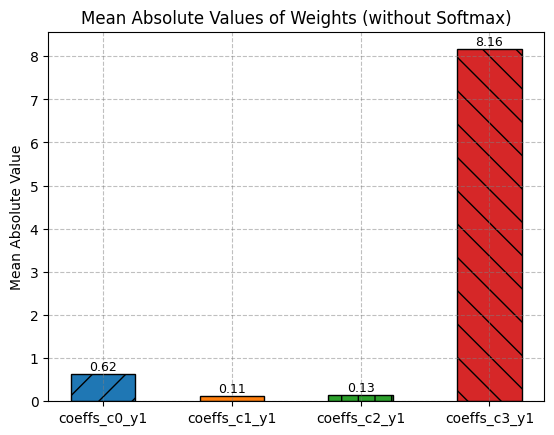

In [7]:
df_1 = df[['coeffs_c0_y1', 'coeffs_c1_y1', 'coeffs_c2_y1', 'coeffs_c3_y1']]

for col in df_1.columns:
    df_1[col] = np.abs(df_1[col])


fig, ax = plt.subplots()


# Assuming df_1 is correctly calculated before this snippet
bar_width = 0.5
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Custom colors for each bar
hatches = ['/', '-', '|', '\\']  # Different hatches for each bar

bars = ax.bar(df_1.columns, df_1.mean(axis=0), bar_width, color=colors, edgecolor='black')

for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)
    
ax.set_ylabel('Mean Absolute Value')
ax.set_title('Mean Absolute Values of Weights (without Softmax)')
ax.grid(True, linestyle='--', which='major', color='gray', alpha=0.5)

# Enhanced label positioning
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.03, f'{yval:.2f}', ha='center', va='bottom', fontsize=9, color='black')

Verifying Results:

In [8]:
llr.explain(x, c_pred, sign_attn, filter_attn, mode='global')

[{'class': 'y_0', 'explanation': 'c_3', 'count': 53},
 {'class': 'y_1', 'explanation': '~c_3', 'count': 47}]

______

In [9]:
x, c, y = datasets.xor(100)

# Encode target into one-hode y=[y_0, y_1]
y = F.one_hot(y.long().ravel()).float()

# Define the concept_encoder
embedding_size = 8
concept_encoder = torch.nn.Sequential(
    torch.nn.Linear(x.shape[1], 10),
    torch.nn.LeakyReLU(),
    te.nn.ConceptEmbedding(10, c.shape[1], embedding_size),
)

# Define the DCR as task predictor
task_predictor = ConceptReasoningLayer(
    embedding_size, y.shape[1])

dummy_c_emb, dummy_c_pred = concept_encoder(x)
dummy_y, dummy_sign, dummy_filter = task_predictor(
    dummy_c_emb, dummy_c_pred, return_attn=True)

global_linearity = ReasoningLinearLayer(
    dummy_sign.shape[1], dummy_filter.shape[1], y.shape[1], modality='NN')

# Create a sequential model (cascaded)
model = torch.nn.Sequential(
    concept_encoder, task_predictor, global_linearity)


model.load_state_dict(torch.load(PATH+'\model_state_dict_LLRNN_XOR.pth'))

<All keys matched successfully>

In [10]:
cem = model[0]
dcr = model[1]
llr = model[2]
cem.eval()
dcr.eval()
llr.eval()
c_emb , c_pred = cem(x)
y_pred, sign_attn, filter_attn = dcr(c_emb, c_pred, return_attn=True)
pred , coeffs, bias = llr(sign_attn, filter_attn, c_pred, return_params=True)

In [11]:
pred = torch.sigmoid(pred) # [0] for y_0, [1] for y_1

In [12]:
df = pd.DataFrame({
    'c_0': c[:, 0],
    'c_1': c[:, 1],
    'y_true_0': y[:, 0],
    'y_true_1': y[:, 1],
    'y_pred_0': pred[:, 0].detach().numpy(),
    'y_pred_1': pred[:, 1].detach().numpy(),
    'coeffs_c0_y0': coeffs[:,0,0].detach().numpy(),
    'coeffs_c1_y0': coeffs[:,1,0].detach().numpy(),
    'coeffs_c0_y1': coeffs[:,0, 1].detach().numpy(),
    'coeffs_c1_y1': coeffs[:,1, 1].detach().numpy(),
    'bias_y0': bias[:, 0].detach().numpy(),
    'bias_y1': bias[:, 1].detach().numpy(),
})

#### Important:
For this dataset, a number is even is the $c_3$ is even (i.e. equal to zero).\
The output of $y_0$ is 0 ($y_1$ is 1) means that the number IS EVEN.

In [13]:
df.head()

,c_0,c_1,y_true_0,y_true_1,y_pred_0,y_pred_1,coeffs_c0_y0,coeffs_c1_y0,coeffs_c0_y1,coeffs_c1_y1,bias_y0,bias_y1
0,0.0,1.0,0.0,1.0,0.000675,0.999319,-0.592649,0.5144,0.592702,-0.514549,-7.814342,7.805490
1,1.0,1.0,1.0,0.0,0.999254,0.000739,-0.592649,0.5144,0.592702,-0.514549,7.278599,-7.287483
2,0.0,0.0,1.0,0.0,0.996876,0.003097,-0.592649,0.5144,0.592702,-0.514549,5.765411,-5.774288
3,0.0,1.0,0.0,1.0,0.000680,0.999314,-0.592649,0.5144,0.592702,-0.514549,-7.807758,7.798901
4,1.0,1.0,1.0,0.0,0.999554,0.000442,-0.592649,0.5144,0.592702,-0.514549,7.791553,-7.800434


#### Average weight: Plotting the average weight of each concept (in absolute value) to analyze its importance
We can focus on $y_1$ since it is TRUE (1) when the number is even

(0.0, 0.6)

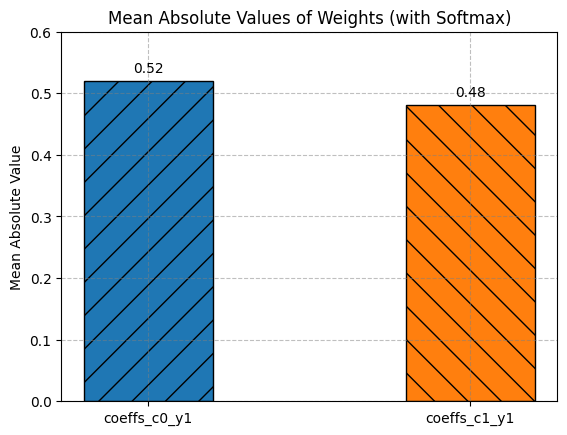

In [14]:
df_1 = df[['coeffs_c0_y1', 'coeffs_c1_y1']]

for col in df_1.columns:
    df_1[col] = np.abs(df_1[col])

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

fig, ax = plt.subplots()

# Assuming df_1 is correctly calculated before this snippet
bar_width = 0.4
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Custom colors for each bar
hatches = ['/', '\\']  # Different hatches for each bar

bars = ax.bar(df_1.columns, softmax(df_1.mean(axis=0)), bar_width, color=colors, edgecolor='black')

for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)

for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', color='black')

ax.set_ylabel('Mean Absolute Value')
ax.set_title('Mean Absolute Values of Weights (with Softmax)')
ax.grid(True, linestyle='--', which='major', color='gray', alpha=0.5)
ax.set_ylim(0, 0.6)


Verifying Results:

In [18]:
llr.explain(x[:10], c_pred[:10], sign_attn[:10], filter_attn[:10], mode='global', log=True)

2024-06-18 20:28:57,766 - torch_explain.nn.concepts - INFO - x: tensor([[0.3745, 0.9507],
        [0.7320, 0.5987],
        [0.1560, 0.1560],
        [0.0581, 0.8662],
        [0.6011, 0.7081],
        [0.0206, 0.9699],
        [0.8324, 0.2123],
        [0.1818, 0.1834],
        [0.3042, 0.5248],
        [0.4319, 0.2912]])
2024-06-18 20:28:57,769 - torch_explain.nn.concepts - INFO - Preds: tensor([[-7.2999,  7.2909],
        [ 7.1999, -7.2089],
        [ 5.7654, -5.7743],
        [-7.2934,  7.2844],
        [ 7.7142, -7.7232],
        [-7.2933,  7.2843],
        [-6.2509,  6.2421],
        [ 5.7662, -5.7751],
        [-5.0838,  5.0748],
        [ 5.7819, -5.7908]], grad_fn=<AddBackward0>)
2024-06-18 20:28:57,773 - torch_explain.nn.concepts - INFO - Transformed Coeffs: tensor([[[-0.5926,  0.5927],
         [ 0.5144, -0.5145]],

        [[-0.5926,  0.5927],
         [ 0.5144, -0.5145]],

        [[-0.5926,  0.5927],
         [ 0.5144, -0.5145]],

        [[-0.5926,  0.5927],
         [ 0

Sign Expr: tensor([ 0.5927, -0.5145], grad_fn=<SelectBackward0>)
Filter Expr: tensor([True, True])
MinTerm: ['c_0']
MinTerm: ['c_0', '~c_1']
Sign Expr: tensor([-0.5926,  0.5144], grad_fn=<SelectBackward0>)
Filter Expr: tensor([True, True])
MinTerm: ['~c_0']
MinTerm: ['~c_0', 'c_1']
Sign Expr: tensor([-0.5926,  0.5144], grad_fn=<SelectBackward0>)
Filter Expr: tensor([True, True])
MinTerm: ['~c_0']
MinTerm: ['~c_0', 'c_1']
Sign Expr: tensor([ 0.5927, -0.5145], grad_fn=<SelectBackward0>)
Filter Expr: tensor([True, True])
MinTerm: ['c_0']
MinTerm: ['c_0', '~c_1']
Sign Expr: tensor([-0.5926,  0.5144], grad_fn=<SelectBackward0>)
Filter Expr: tensor([True, True])
MinTerm: ['~c_0']
MinTerm: ['~c_0', 'c_1']
Sign Expr: tensor([ 0.5927, -0.5145], grad_fn=<SelectBackward0>)
Filter Expr: tensor([True, True])
MinTerm: ['c_0']
MinTerm: ['c_0', '~c_1']
Sign Expr: tensor([ 0.5927, -0.5145], grad_fn=<SelectBackward0>)
Filter Expr: tensor([True, True])
MinTerm: ['c_0']
MinTerm: ['c_0', '~c_1']
Sign Expr:

[{'class': 'y_0', 'explanation': '~c_0 & c_1', 'count': 5},
 {'class': 'y_1', 'explanation': 'c_0 & ~c_1', 'count': 5}]